PNEUMONIA DETECTION

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import zipfile
import os

def extract_zip(zip_path, extract_to_folder):
    """
    Extracts a zip file to the specified folder.

    :param zip_path: Path to the zip file.
    :param extract_to_folder: Directory where the contents should be extracted.
    """
    # Check if the destination folder exists, if not, create it
    if not os.path.exists(extract_to_folder):
        os.makedirs(extract_to_folder)

    # Open the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extract all the contents into the directory
        zip_ref.extractall(extract_to_folder)

    print(f"Extracted all files to {extract_to_folder}")

# Example usage
zip_file_path = '/content/drive/MyDrive/archive.zip'  # Path to your zip file
destination_folder = '/content/chest'  # Folder where you want to extract the files

extract_zip(zip_file_path, destination_folder)


Extracted all files to /content/chest


In [23]:


import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/content/chest'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Streaming output truncated to the last 5000 lines.
/content/chest/chest_xray/chest_xray/train/PNEUMONIA/person1465_virus_2537.jpeg
/content/chest/chest_xray/chest_xray/train/PNEUMONIA/person688_virus_1282.jpeg
/content/chest/chest_xray/chest_xray/train/PNEUMONIA/person23_bacteria_86.jpeg
/content/chest/chest_xray/chest_xray/train/PNEUMONIA/person12_bacteria_46.jpeg
/content/chest/chest_xray/chest_xray/train/PNEUMONIA/person894_virus_1546.jpeg
/content/chest/chest_xray/chest_xray/train/PNEUMONIA/person855_bacteria_2777.jpeg
/content/chest/chest_xray/chest_xray/train/PNEUMONIA/person1268_bacteria_3228.jpeg
/content/chest/chest_xray/chest_xray/train/PNEUMONIA/person124_virus_251.jpeg
/content/chest/chest_xray/chest_xray/train/PNEUMONIA/person260_bacteria_1223.jpeg
/content/chest/chest_xray/chest_xray/train/PNEUMONIA/person38_bacteria_190.jpeg
/content/chest/chest_xray/chest_xray/train/PNEUMONIA/person456_bacteria_1948.jpeg
/content/chest/chest_xray/chest_xray/train/PNEUMONIA/person1880_ba

IMPORTING NECESSARY LIBRARIES

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [25]:
import numpy as np
import pandas as pd
import os
import cv2

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    # Convert the list of lists to a NumPy array with 'object' dtype to handle varying shapes
    return np.array(data, dtype=object)

LOADING DATASET

In [26]:
train = get_training_data('/content/chest/chest_xray/train')
test = get_training_data('/content/chest/chest_xray/test')
val = get_training_data('/content/chest/chest_xray/val')

<Axes: xlabel='count'>

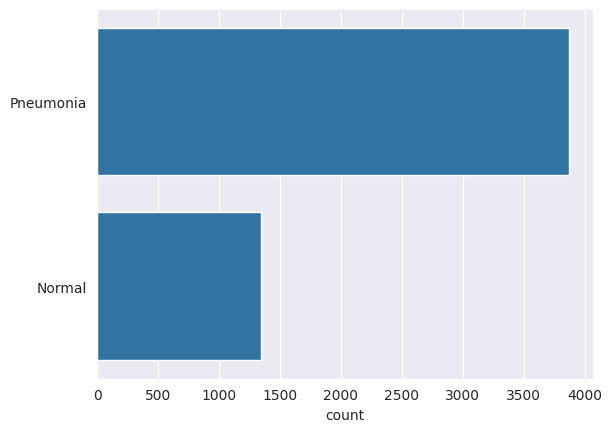

In [27]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

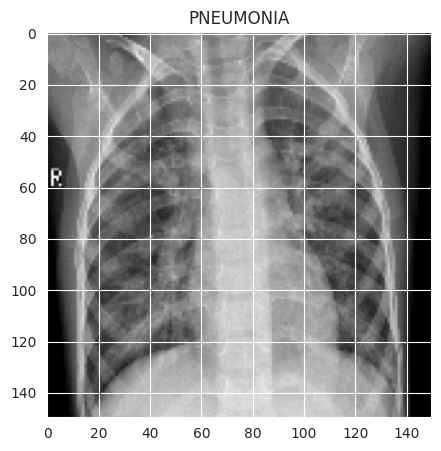

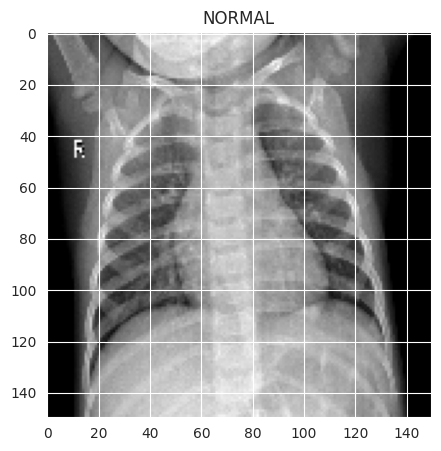

In [28]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [29]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [30]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [31]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [32]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [33]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [34]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [35]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 4, validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 627s 4s/step - accuracy: 0.8034 - loss: 0.9339 - val_accuracy: 0.5000 - val_loss: 50.5024 - learning_rate: 0.0010
Epoch 2/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 620s 4s/step - accuracy: 0.8917 - loss: 0.2694 - val_accuracy: 0.5000 - val_loss: 45.4812 - learning_rate: 0.0010
Epoch 3/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9140 - loss: 0.2297
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 611s 4s/step - accuracy: 0.9141 - loss: 0.2297 - val_accuracy: 0.5000 - val_loss: 69.3323 - learning_rate: 0.0010
Epoch 4/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 605s 4s/step - accuracy: 0.9441 - loss: 0.1581 - val_accuracy: 0.5625 - val_loss: 4.5465 - learning_rate: 3.0000e-04


In [36]:
model.save('my_model1.keras')

In [37]:
model=keras.models.load_model('my_model1.keras')

In [38]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 694ms/step - accuracy: 0.9038 - loss: 0.3277
Loss of the model is -  0.6436722874641418
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 735ms/step - accuracy: 0.9038 - loss: 0.3277
Accuracy of the model is -  89.26281929016113 %


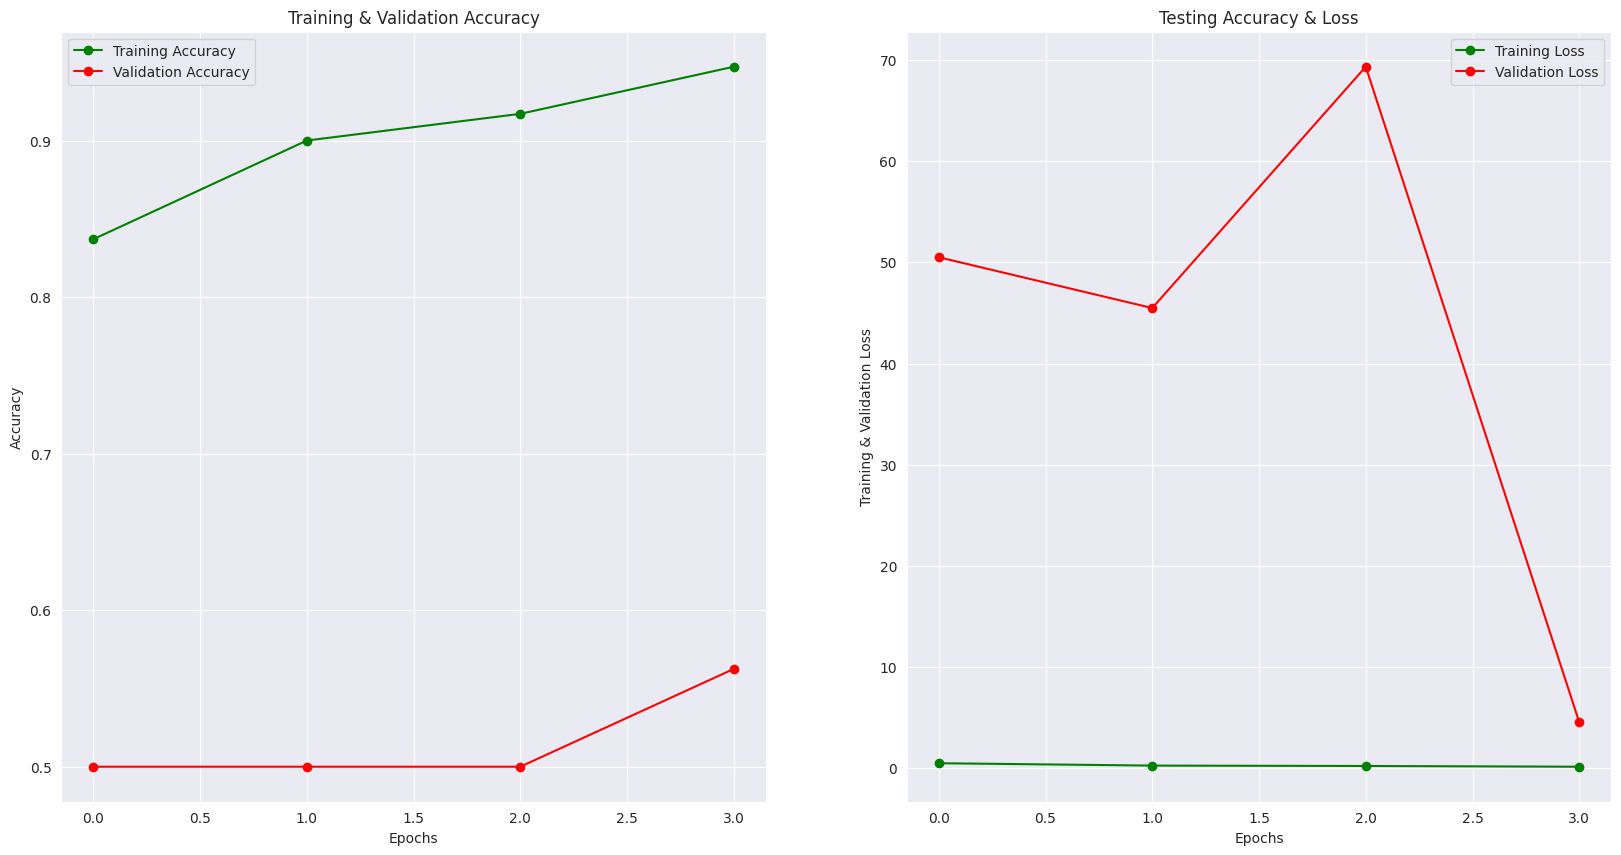

In [39]:
epochs = [i for i in range(4)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [40]:
predictions = (model.predict(x_test) > 0.5).astype("int32") # Get predictions as probabilities and convert to class labels (0 or 1 assuming binary classification)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 734ms/step


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [41]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.93      0.92       390
   Normal (Class 1)       0.88      0.83      0.85       234

           accuracy                           0.89       624
          macro avg       0.89      0.88      0.88       624
       weighted avg       0.89      0.89      0.89       624



In [42]:
cm = confusion_matrix(y_test,predictions)
cm

array([[363,  27],
       [ 40, 194]])

In [43]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

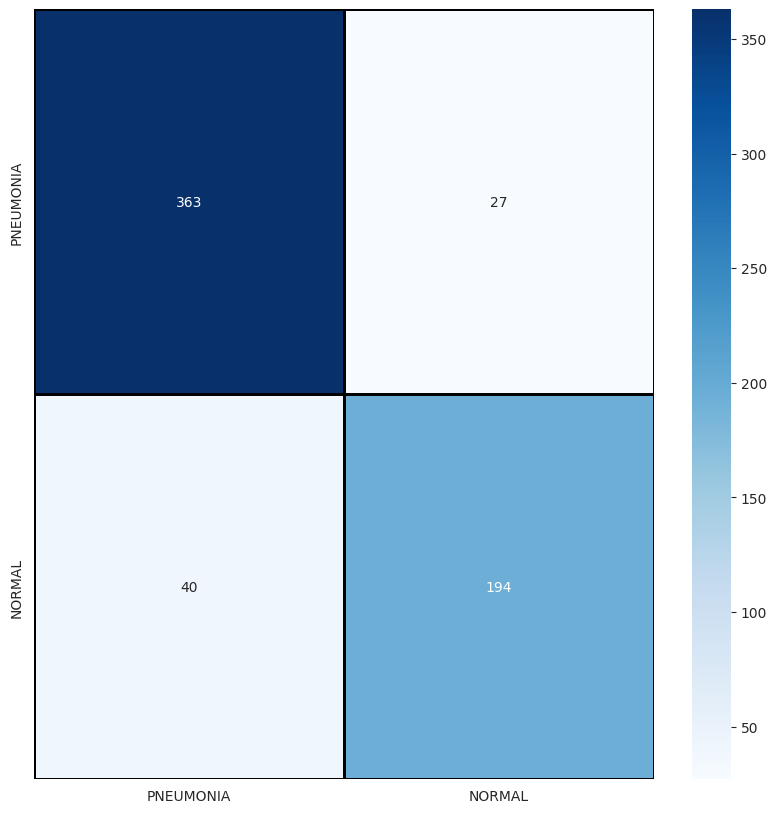

In [44]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [45]:
def predict_single_image(image_path, model, img_size=150):
    # Load and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalize
    img = img.reshape(1, img_size, img_size, 1)  # Reshape for model input

    # Predict the class
    prediction = model.predict(img)
    predicted_class = (prediction > 0.5).astype("int32")[0][0]

    # Convert numerical class to label
    class_label = 'Pneumonia' if predicted_class == 0 else 'Normal'

    return class_label, prediction[0][0]

# Example usage:
image_path = '/content/chest/chest_xray/test/NORMAL/IM-0001-0001.jpeg'  # Replace with the path to the image you want to test
class_label, probability = predict_single_image(image_path, model)

print(f"Predicted Class: {class_label}")
print(f"Probability: {probability}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Class: Normal
Probability: 0.9451118111610413


In [46]:
image_path = '/content/chest/chest_xray/test/PNEUMONIA/person104_bacteria_491.jpeg'  # Replace with the path to the image you want to test
class_label, probability = predict_single_image(image_path, model)

print(f"Predicted Class: {class_label}")
print(f"Probability: {probability}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted Class: Pneumonia
Probability: 1.179976762722074e-19


In [47]:
pip install Flask keras tensorflow numpy pandas opencv-python matplotlib seaborn
